In [1]:
%%capture --no-stderr
%pip install -q -U langchain
%pip install -q -U langchain-google-genai
%pip install -q -U langgraph

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage

In [3]:
from google.colab import userdata
google_api_key = userdata.get("GEMINI_API_KEY")

In [4]:
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)

In [7]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

In [8]:
from typing_extensions import TypedDict

class TextAnalysisState(TypedDict):
  text: str
  classification: str
  entities: str
  summary: str

In [22]:
def classification_node(state: TextAnalysisState):
  text: str = state["text"]

  prompt: str = """
You will receive a text input, and your task is to classify
the text into one of the following categories: News, Blog,
Research, or Other.

Based on the content, choose the most appropriate category.

Return only the category name.

The text is: {text}"""

  llm_response: AIMessage = llm.invoke(prompt.format(text=text))

  return {
    "classification": llm_response.content
  }

In [49]:
def summarization_node(state: TextAnalysisState):
  text: str = state["text"]

  prompt: str = """
  Summarise the following text:

  {text}
  """

  llm_response: AIMessage = llm.invoke(prompt.format(text=text))

  return {
    "summary": llm_response.content
  }

In [54]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

builder: StateGraph = StateGraph(state_schema=TextAnalysisState)

builder.add_node("Classification Node", classification_node)
builder.add_node("Entity Extraction Node", entity_extraction_node)
builder.add_node("Summarization Node", summarization_node)

builder.add_edge(START, "Classification Node")
builder.add_edge("Classification Node", "Entity Extraction Node")
builder.add_edge("Entity Extraction Node", "Summarization Node")
builder.add_edge("Summarization Node", END)

graph: CompiledStateGraph = builder.compile()

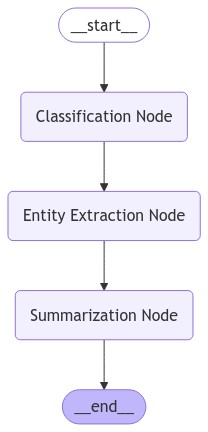

In [79]:
from IPython.display import Markdown, Image, display

Image(graph.get_graph().draw_mermaid_png())

In [80]:
text: str = """
Introducing OpenAI o1-preview
A new series of reasoning models for solving hard problems. Available now.

Update on September 17, 2024: Rate limits are now 50 queries per week for o1-preview and 50 queries per day for o1-mini.

We've developed a new series of AI models designed to spend more time thinking before they respond. They can reason through complex tasks and solve harder problems than previous models in science, coding, and math.

Today, we are releasing the first of this series in ChatGPT and our API. This is a preview and we expect regular updates and improvements. Alongside this release, we’re also including evaluations for the next update, currently in development.

How it works
We trained these models to spend more time thinking through problems before they respond, much like a person would. Through training, they learn to refine their thinking process, try different strategies, and recognize their mistakes.

In our tests, the next model update performs similarly to PhD students on challenging benchmark tasks in physics, chemistry, and biology. We also found that it excels in math and coding. In a qualifying exam for the International Mathematics Olympiad (IMO), GPT-4o correctly solved only 13% of problems, while the reasoning model scored 83%. Their coding abilities were evaluated in contests and reached the 89th percentile in Codeforces competitions. You can read more about this in our technical research post.

As an early model, it doesn't yet have many of the features that make ChatGPT useful, like browsing the web for information and uploading files and images. For many common cases GPT-4o will be more capable in the near term.

But for complex reasoning tasks this is a significant advancement and represents a new level of AI capability. Given this, we are resetting the counter back to 1 and naming this series OpenAI o1.

Safety
As part of developing these new models, we have come up with a new safety training approach that harnesses their reasoning capabilities to make them adhere to safety and alignment guidelines. By being able to reason about our safety rules in context, it can apply them more effectively.

One way we measure safety is by testing how well our model continues to follow its safety rules if a user tries to bypass them (known as "jailbreaking"). On one of our hardest jailbreaking tests, GPT-4o scored 22 (on a scale of 0-100) while our o1-preview model scored 84. You can read more about this in the system card and our research post.

To match the new capabilities of these models, we’ve bolstered our safety work, internal governance, and federal government collaboration. This includes rigorous testing and evaluations using our Preparedness Framework(opens in a new window), best-in-class red teaming, and board-level review processes, including by our Safety & Security Committee.

To advance our commitment to AI safety, we recently formalized agreements with the U.S. and U.K. AI Safety Institutes. We've begun operationalizing these agreements, including granting the institutes early access to a research version of this model. This was an important first step in our partnership, helping to establish a process for research, evaluation, and testing of future models prior to and following their public release.

Whom it’s for
These enhanced reasoning capabilities may be particularly useful if you’re tackling complex problems in science, coding, math, and similar fields. For example, o1 can be used by healthcare researchers to annotate cell sequencing data, by physicists to generate complicated mathematical formulas needed for quantum optics, and by developers in all fields to build and execute multi-step workflows.
"""
result = graph.invoke({"text": text})
result

{'text': '\nIntroducing OpenAI o1-preview\nA new series of reasoning models for solving hard problems. Available now.\n\nUpdate on September 17, 2024: Rate limits are now 50 queries per week for o1-preview and 50 queries per day for o1-mini.\n\nWe\'ve developed a new series of AI models designed to spend more time thinking before they respond. They can reason through complex tasks and solve harder problems than previous models in science, coding, and math.\n\nToday, we are releasing the first of this series in ChatGPT and our API. This is a preview and we expect regular updates and improvements. Alongside this release, we’re also including evaluations for the next update, currently in development.\n\nHow it works\nWe trained these models to spend more time thinking through problems before they respond, much like a person would. Through training, they learn to refine their thinking process, try different strategies, and recognize their mistakes. \n\nIn our tests, the next model update p

In [81]:
print("Classification:", result["classification"])

Classification: Blog 



In [82]:
print("Entities:", result["entities"])

Entities: ['OpenAI, ChatGPT, GPT-4o, International Mathematics Olympiad (IMO), Codeforces, U.S. AI Safety Institutes, U.K. AI Safety Institutes \n']


In [92]:
print("Summary:", result["summary"])

Summary: OpenAI has released a new series of AI models called "o1-preview" that are designed to excel at complex reasoning tasks, outperforming previous models in areas like science, coding, and math. These models are trained to think more deeply and strategically, resembling human problem-solving processes. 

They demonstrate impressive capabilities, achieving scores comparable to PhD students on challenging benchmarks and surpassing GPT-4o in math and coding tasks. 

While they are still in early development and lack features like web browsing, their advanced reasoning abilities make them a significant advancement in AI. OpenAI has also implemented new safety measures tailored to these reasoning capabilities, resulting in significantly improved jailbreaking resistance. 

These models are targeted towards users working on complex problems in science, coding, and math, offering potential applications in fields like healthcare research, physics, and software development. 

